<a href="https://colab.research.google.com/github/AlonResearch/SNN-for-MI-EEG/blob/main/MI3_SNNforMIeeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np
import torch
import torch.utils.data as da
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import scipy.io as scio
#!pip install spikingjelly -q
from spikingjelly.activation_based import ann2snn
#!apt install -y graphviz graphviz-dev -q
#!pip install nnviz -q
from nnviz import drawing
import matplotlib.pyplot as plt


In [9]:

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
!nvidia-smi

Using cuda device
Wed May  7 07:48:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   78C    P0             70W /   70W |    1192MiB /  15360MiB |     85%      Default |
|                                         |                        |                  N/A |
+-----------------------------

In [3]:
# @title Data loader and other functions
#Defining functions

def data_loader(data, label, batch=64, shuffle=True, drop=False):
    """
    Preprocess the data to fit model.
    Feed data into data_loader.
    input:
        data (float): samples*length*ch (samples*ch*length).
        label (int): samples, ie.: [0, 1, 1, 0, ..., 2].
        batch (int): batch size
        shuffle (bool): shuffle data before input into decoder
        drop (bool): drop the last samples if True
    output:
        data loader
    """
    label = torch.LongTensor(label.flatten()).to(device)
    if data.shape[1] >= data.shape[2]:
        data = torch.tensor(data.swapaxes(1, 2))
    data = torch.unsqueeze(data, dim=1).type('torch.FloatTensor').to(device)
    data = da.TensorDataset(data, label)
    loader = da.DataLoader(dataset=data, batch_size=batch, shuffle=shuffle, drop_last=drop)
    return loader


def val_snn(Dec, test_loader, T=None):
    Dec.eval().to(device)
    correct = 0
    total = 0
    if T is not None:
        corrects = np.zeros(T)
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            if T is None:
                outputs = Dec(inputs)
                correct += (outputs.argmax(dim=1) == targets.to(device)).float().sum().item()
            else:
                for m in Dec.modules():
                    if hasattr(m, 'reset'):
                        m.reset()
                for t in range(T):
                    if t == 0:
                        outputs = Dec(inputs)
                    else:
                        outputs += Dec(inputs)
                    corrects[t] += (outputs.argmax(dim=1) == targets.to(device)).float().sum().item()
            total += targets.shape[0]
    return correct / total if T is None else corrects / total


def anntosnn(cnn_model, train_x, train_y, test_x, test_y, batch=64, T=None):
    # Define data loader
    train_loader = data_loader(train_x, train_y, batch=batch)
    test_loader = data_loader(test_x, test_y, batch=batch)

    print('---------------------------------------------')
    print('Converting using MaxNorm')
    model_converter = ann2snn.Converter(mode='max', dataloader=train_loader)
    snn_model = model_converter(cnn_model)
    mode_max_accs = val_snn(snn_model, test_loader, T=T)

    return mode_max_accs


torch.backends.cudnn.benchmark = True

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
        elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)


def train_ann(cnn_model, train_x, train_y, test_x, test_y, ep=500, batch=64):
    """
    input:
        train_x, test_x (float): samples*length*ch (samples*ch*length).
        train_y, test_y (int): samples, ie.: [0, 1, 1, 0, ..., 2].
        ep (int): total train and test epoch
        batch (int): batch size
    output:
        train acc, test acc, weight_file
    """
    # Define training configuration
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.01)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=ep)

    # Define data loader
    train_loader = data_loader(train_x, train_y, batch=batch)
    test_loader = data_loader(test_x, test_y, batch=batch)

    train_acc = []
    test_acc = []
    for epoch in range(ep):
        # Train ANN
        cnn_model.train()
        train_loss = 0
        correct = 0
        total = 0
        loss = 0
        print('\n')
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = cnn_model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            print(batch_idx, len(train_loader), 'Epoch: %d | ANN: trainLoss: %.4f | trainAcc: %.4f%% (%d/%d)'
                  % (epoch, train_loss / (batch_idx + 1), 100. * correct / total, correct, total))

        lr_scheduler.step()
        train_acc.append(round(correct / total, 4))

        # Test ANN
        cnn_model.eval()
        val_loss = 0
        correct = 0
        total = 0
        loss = 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(test_loader):
                outputs = cnn_model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                print(batch_idx, len(test_loader), 'Epoch: %d | ANN: testLoss: %.4f | testAcc: %.4f%% (%d/%d)'
                      % (epoch, val_loss / (batch_idx + 1), 100. * correct / total, correct, total))

        test_acc.append(round(correct / total, 4))

    train_acc = np.asarray(train_acc[-1])
    test_acc = np.asarray(test_acc[-1])
    return train_acc, test_acc,cnn_model

In [17]:
# @title Model definitions
# Model 2a

class LENet(nn.Module):
    """
        LENet Model
    input:
         data shape as: batch_size*1*channel*length (64*1*22*1000) BCI IV-2a
         batch_size：64
         channel：22
         length：1000
    output:
        classes_num
    """

    def __init__(self, classes_num=3, channel_count=22, drop_out = 0.5):
        super(LENet, self).__init__()
        self.drop_out = drop_out

        self.block_TCB_1 = nn.Sequential(
            # Temporal Convolution block kernel_size (1,64) #
            nn.ZeroPad2d((32, 31, 0, 0)),
            nn.Conv2d(
                in_channels=1,
                out_channels=8,
                kernel_size=(1, 64),
                bias=False,
            ),
            nn.BatchNorm2d(8)
        )
        self.block_TCB_2 = nn.Sequential(
            # Temporal Convolution block kernel_size (1,32) #
            nn.ZeroPad2d((16, 15, 0, 0)),
            nn.Conv2d(
                in_channels=1,
                out_channels=8,
                kernel_size=(1, 32),
                bias=False,
            ),
            nn.BatchNorm2d(8)
        )
        self.block_TCB_3 = nn.Sequential(
            # Temporal Convolution block kernel_size (1,16) #
            nn.ZeroPad2d((8, 7, 0, 0)),
            nn.Conv2d(
                in_channels=1,
                out_channels=8,
                kernel_size=(1, 16),
                bias=False,
            ),
            nn.BatchNorm2d(8)
        )

        self.TCB_fusion = nn.Sequential(
            # Temporal Convolution block fusion kernel_size (1,1) #
            nn.Conv2d(
                in_channels=24,
                out_channels=24,
                kernel_size=(1, 1),
                bias=False,
            ),
            nn.BatchNorm2d(24)
        )

        self.SCB = nn.Sequential(
            # Spatial Convolution block kernel_size (channel,1) #
            nn.Conv2d(
                in_channels=24,
                out_channels=16,
                kernel_size=(channel_count, 1),
                groups=8,
                bias=False
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(self.drop_out)
        )

        self.FFCB = nn.Sequential(
            # Feature Fusion Convolution block kernel_size (1,16) and (1,1) #
            nn.ZeroPad2d((7, 8, 0, 0)),
            nn.Conv2d(
                in_channels=16,
                out_channels=16,
                kernel_size=(1, 16),
                groups=16,
                bias=False
            ),
            nn.Conv2d(
                in_channels=16,
                out_channels=16,
                kernel_size=(1, 1),
                bias=False
            ),  #
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(self.drop_out)
        )

        self.CCB = nn.Sequential(
            # Classification Convolution block kernel_size (1,1) #
            nn.Conv2d(
                in_channels=16,
                out_channels=classes_num,
                kernel_size=(1, 1),
                bias=False
            ),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
        )

    def forward(self, x):
        x1 = self.block_TCB_1(x)
        x2 = self.block_TCB_2(x)
        x3 = self.block_TCB_3(x)
        x4 = torch.cat([x1, x2, x3], dim=1)
        x = self.TCB_fusion(x4)
        x = self.SCB(x)
        x = self.FFCB(x)
        x = self.CCB(x)
        return x

class LENet_FCL(nn.Module):
    def __init__(self, classes_num=3, channel_count=60, drop_out=0.5):
        super(LENet_FCL, self).__init__()
        self.drop_out = drop_out

        # Keep all the convolutional layers the same
        self.block_TCB_1 = nn.Sequential(
            nn.ZeroPad2d((32, 31, 0, 0)),
            nn.Conv2d(
                in_channels=1,
                out_channels=8,
                kernel_size=(1, 64),
                bias=False,
            ),
            nn.BatchNorm2d(8)
        )
        self.block_TCB_2 = nn.Sequential(
            nn.ZeroPad2d((16, 15, 0, 0)),
            nn.Conv2d(
                in_channels=1,
                out_channels=8,
                kernel_size=(1, 32),
                bias=False,
            ),
            nn.BatchNorm2d(8)
        )
        self.block_TCB_3 = nn.Sequential(
            nn.ZeroPad2d((8, 7, 0, 0)),
            nn.Conv2d(
                in_channels=1,
                out_channels=8,
                kernel_size=(1, 16),
                bias=False,
            ),
            nn.BatchNorm2d(8)
        )

        self.TCB_fusion = nn.Sequential(
            nn.Conv2d(
                in_channels=24,
                out_channels=24,
                kernel_size=(1, 1),
                bias=False,
            ),
            nn.BatchNorm2d(24)
        )

        self.SCB = nn.Sequential(
            nn.Conv2d(
                in_channels=24,
                out_channels=16,
                kernel_size=(channel_count, 1),
                groups=8,
                bias=False
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(self.drop_out)
        )

        self.FFCB = nn.Sequential(
            nn.ZeroPad2d((7, 8, 0, 0)),
            nn.Conv2d(
                in_channels=16,
                out_channels=16,
                kernel_size=(1, 16),
                groups=16,
                bias=False
            ),
            nn.Conv2d(
                in_channels=16,
                out_channels=16,
                kernel_size=(1, 1),
                bias=False
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(self.drop_out)
        )

        # We'll determine the size of the FC layer in the forward pass
        self.flatten = nn.Flatten()
        self.fc = None
        self.classes_num = classes_num

    def forward(self, x):
        x1 = self.block_TCB_1(x)
        x2 = self.block_TCB_2(x)
        x3 = self.block_TCB_3(x)
        x4 = torch.cat([x1, x2, x3], dim=1)
        x = self.TCB_fusion(x4)
        x = self.SCB(x)
        x = self.FFCB(x)

        # Flatten the output
        x = self.flatten(x)

        # Create the FC layer on first forward pass if it doesn't exist
        if self.fc is None:
            in_features = x.shape[1]
            self.fc = nn.Linear(in_features, self.classes_num).to(x.device)
            # Initialize weights for the new layer
            nn.init.kaiming_normal_(self.fc.weight, mode="fan_out", nonlinearity="relu")
            if self.fc.bias is not None:
                nn.init.constant_(self.fc.bias, 0)

        # Apply the FC layer
        x = self.fc(x)
        return x

In [18]:
# @title Loading the data
"""
Loading the data
"""

# Getting real samples
#Locally load the dataset
#file = scio.loadmat('Datasets\BCICIV_2a_gdf\Derivatives\A01T.mat')

# Google Colab load the dataset
file = scio.loadmat('/content/sub-011_eeg.mat')


all_data = file['all_data']
all_label = file['all_label']

# Print data information
channel_count = all_data.shape[1]
num_classes = len(np.unique(all_label.flatten()))
data_length = all_data.shape[2] # Assuming data is samples*ch*length
print(f"Channel count: {channel_count}")
print(f"Data shape: {all_data.shape}")
print(f"Label shape: {all_label.shape}")
print(f"Class distribution: Rest: {np.sum(all_label == 0)}, Elbow: {np.sum(all_label == 1)}, Hand: {np.sum(all_label == 2)}")

datasetX = torch.tensor(all_data, dtype=torch.float32)
datasetY = torch.tensor(all_label, dtype=torch.int64)

Channel count: 62
Data shape: (965, 62, 4000)
Label shape: (965, 1)
Class distribution: Rest: 365, Elbow: 300, Hand: 300


In [22]:
# @title LENet to SNN Conversion Framework execution

# Hyperparameters
EPOCHS = 60
BATCH_SIZE = 64
TIME_STEPS = 100  # T for SNN
TEST_SIZE = 0.1
DROP_OUT = 0.25

# Split the data
print(f"{100 - (TEST_SIZE * 100)}% of the dataset is used for training and {TEST_SIZE * 100}% is used for testing.")
train_data, test_data, train_label, test_label = train_test_split(datasetX, datasetY, test_size=TEST_SIZE, shuffle=True,
                                                                  random_state=0)

# Initialize model
cnn_model_lenet = LENet(classes_num=3, channel_count=channel_count, drop_out = DROP_OUT).to(device)
cnn_model_lenet.apply(initialize_weights)

# Train CNN model
train_acc, test_acc,  cnn_model_lenet = train_ann(cnn_model_lenet, train_data, train_label, test_data, test_label,
                                              ep=EPOCHS, batch=BATCH_SIZE)
max_norm_acc = anntosnn( cnn_model_lenet, train_data, train_label, test_data, test_label,
                        batch=BATCH_SIZE, T=TIME_STEPS)
snn_model_lenet = ann2snn.Converter(mode='max', dataloader=data_loader(train_data, train_label, batch=BATCH_SIZE))( cnn_model_lenet)

print('\n')
print('ANN accuracy: Test: %.4f%%' % (test_acc * 100))
print('SNN accuracy: max_norm: %.4f%%' % (max_norm_acc[-1] * 100))

90.0% of the dataset is used for training and 10.0% is used for testing.


0 14 Epoch: 0 | ANN: trainLoss: 1.3130 | trainAcc: 29.6875% (19/64)
1 14 Epoch: 0 | ANN: trainLoss: 1.3082 | trainAcc: 27.3438% (35/128)
2 14 Epoch: 0 | ANN: trainLoss: 1.2498 | trainAcc: 30.7292% (59/192)
3 14 Epoch: 0 | ANN: trainLoss: 1.2140 | trainAcc: 33.9844% (87/256)
4 14 Epoch: 0 | ANN: trainLoss: 1.1902 | trainAcc: 34.6875% (111/320)
5 14 Epoch: 0 | ANN: trainLoss: 1.1692 | trainAcc: 35.4167% (136/384)
6 14 Epoch: 0 | ANN: trainLoss: 1.1471 | trainAcc: 37.9464% (170/448)
7 14 Epoch: 0 | ANN: trainLoss: 1.1390 | trainAcc: 38.4766% (197/512)
8 14 Epoch: 0 | ANN: trainLoss: 1.1343 | trainAcc: 38.5417% (222/576)
9 14 Epoch: 0 | ANN: trainLoss: 1.1232 | trainAcc: 39.8438% (255/640)
10 14 Epoch: 0 | ANN: trainLoss: 1.1176 | trainAcc: 40.4830% (285/704)
11 14 Epoch: 0 | ANN: trainLoss: 1.1157 | trainAcc: 40.8854% (314/768)
12 14 Epoch: 0 | ANN: trainLoss: 1.1090 | trainAcc: 41.7067% (347/832)
13 14 Epoch: 0 | 

100%|██████████| 14/14 [00:00<00:00, 363.45it/s]




ANN accuracy: Test: 68.0400%
SNN accuracy: max_norm: 68.0412%


In [20]:
# @title NN Visualization

# This block should be placed after the training and SNN conversion
# of the model you wish to visualize. For example, after the
# "LENet to SNN Conversion Framework execution" cell or
# after the "LENet_FCL to SNN Conversion Framework execution" cell.
# The `cnn_model_lenet` and `Snn_model_lenet` variables from that preceding cell
# will be used for visualization.

# Install nnviz if you haven't already (uncomment the line below if needed)
# !pip install nnviz

# Import necessary nnviz modules
from nnviz import drawing, inspection
import torch # Ensure torch is imported

print("Starting Neural Network Visualization...")

# --- CNN Model Visualization ---
if 'cnn_model_lenet' in locals() and isinstance(cnn_model_lenet, torch.nn.Module):
    model_to_visualize_cnn = cnn_model_lenet
    cnn_model_lenet_name = type(model_to_visualize_cnn).__name__
    print(f"\nVisualizing LENet CNN model: {cnn_model_lenet_name}")

    try:
        # Move model to CPU for inspection (safer for fx tracing)
        cnn_model_lenet_cpu = model_to_visualize_cnn.to('cpu')

        # Create an inspector
        # TorchFxInspector uses torch.fx to trace the model graph
        cnn_inspector = inspection.TorchFxInspector()

        # Inspect the CNN model
        # For models like LENet_FCL, training (as done in your script) ensures that
        # dynamically created layers (e.g., self.fc) are initialized before inspection.
        print(f"Inspecting {cnn_model_lenet_name} on CPU...")
        cnn_graph = cnn_inspector.inspect(cnn_model_lenet_cpu)

        # Create a drawer for saving the visualization (e.g., to a PDF file)
        # You can change the output format by changing the extension (e.g., .png, .svg)
        cnn_viz_filename = f"{cnn_model_lenet_name}_LENet_cnn_architecture.png"
        cnn_drawer = drawing.GraphvizDrawer(cnn_viz_filename)

        # Draw the graph and save it to the file
        cnn_drawer.draw(cnn_graph)
        print(f"LENet CNN model visualization saved to: {cnn_viz_filename}")
        print(
            f"Note: If the output file is empty or shows an error, ensure Graphviz "
            f"(specifically the 'dot' command) is installed and accessible in your system's PATH."
        )

    except Exception as e:
        print(
            f"An error occurred during CNN model ({cnn_model_lenet_name}) visualization: {e}"
        )
        print("Troubleshooting tips:")
        print("- Ensure 'nnviz' is installed.")
        print(
            "- Ensure 'graphviz' (dot executable) is installed and in your system's PATH."
        )
        print(
            "- The model structure might contain operations not traceable by torch.fx. "
            "Check nnviz documentation for advanced usage or alternative inspectors if needed."
        )
else:
    print(
        "\nCNN model ('cnn_model_lenet') not found in the current scope, or it's not a torch.nn.Module. "
        "Skipping CNN visualization."
    )
print("\nNeural Network Visualization process complete.")

Starting Neural Network Visualization...

CNN model ('cnn_model_lenet') not found in the current scope, or it's not a torch.nn.Module. Skipping CNN visualization.

Neural Network Visualization process complete.


In [24]:
# @title LENet_FCL to SNN Conversion Framework execution

# Hyperparameters
EPOCHS = 60
BATCH_SIZE = 64
TIME_STEPS = 100  # T for SNN
TEST_SIZE = 0.1
DROP_OUT = 0.2


# Split the data
print(f"{100 - (TEST_SIZE * 100)}% of the dataset is used for training and {TEST_SIZE * 100}% is used for testing.")
train_data, test_data, train_label, test_label = train_test_split(datasetX, datasetY, test_size=TEST_SIZE, shuffle=True,
                                                                  random_state=0)

# Initialize model
cnn_model_lenet_fcl = LENet_FCL(classes_num=3, channel_count=channel_count, drop_out = DROP_OUT).to(device)
cnn_model_lenet_fcl.apply(initialize_weights)

# Train CNN model
train_acc, test_acc,  cnn_model_lenet_fcl = train_ann(cnn_model_lenet_fcl, train_data, train_label, test_data, test_label,
                                              ep=EPOCHS, batch=BATCH_SIZE)
max_norm_acc = anntosnn( cnn_model_lenet_fcl, train_data, train_label, test_data, test_label,
                        batch=BATCH_SIZE, T=TIME_STEPS)
snn_model_lenet_fcl = ann2snn.Converter(mode='max', dataloader=data_loader(train_data, train_label, batch=BATCH_SIZE))( cnn_model)

print('\n')
print('ANN accuracy: Test: %.4f%%' % (test_acc * 100))
print('SNN accuracy: max_norm: %.4f%%' % (max_norm_acc[-1] * 100))

90.0% of the dataset is used for training and 10.0% is used for testing.


0 14 Epoch: 0 | ANN: trainLoss: 13.5148 | trainAcc: 40.6250% (26/64)
1 14 Epoch: 0 | ANN: trainLoss: 13.2169 | trainAcc: 35.9375% (46/128)
2 14 Epoch: 0 | ANN: trainLoss: 12.9593 | trainAcc: 36.4583% (70/192)
3 14 Epoch: 0 | ANN: trainLoss: 12.7848 | trainAcc: 36.7188% (94/256)
4 14 Epoch: 0 | ANN: trainLoss: 11.7772 | trainAcc: 36.8750% (118/320)
5 14 Epoch: 0 | ANN: trainLoss: 11.2119 | trainAcc: 38.8021% (149/384)
6 14 Epoch: 0 | ANN: trainLoss: 10.7812 | trainAcc: 38.1696% (171/448)
7 14 Epoch: 0 | ANN: trainLoss: 10.3474 | trainAcc: 37.8906% (194/512)
8 14 Epoch: 0 | ANN: trainLoss: 10.1498 | trainAcc: 37.5000% (216/576)
9 14 Epoch: 0 | ANN: trainLoss: 10.1368 | trainAcc: 36.5625% (234/640)
10 14 Epoch: 0 | ANN: trainLoss: 9.7865 | trainAcc: 37.0739% (261/704)
11 14 Epoch: 0 | ANN: trainLoss: 9.5182 | trainAcc: 37.1094% (285/768)
12 14 Epoch: 0 | ANN: trainLoss: 9.1674 | trainAcc: 37.3798% (311/832)
13 14 E

100%|██████████| 14/14 [00:00<00:00, 264.61it/s]




ANN accuracy: Test: 63.9200%
SNN accuracy: max_norm: 63.9175%


Evaluating LENet CNN...
Evaluating LENet SNN...
Evaluating LENet_FCL CNN...
Evaluating LENet_FCL SNN...


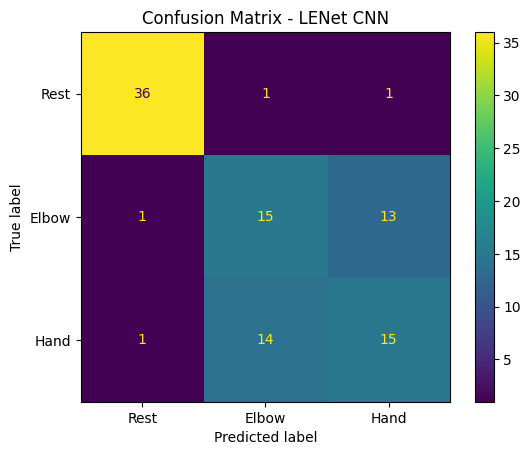

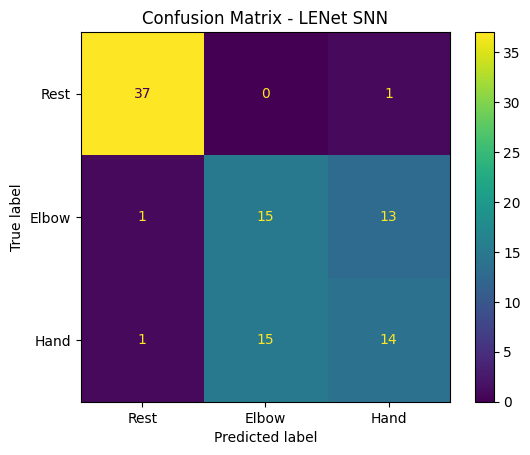

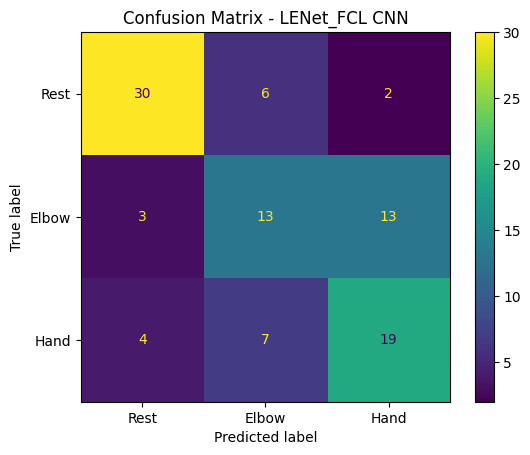

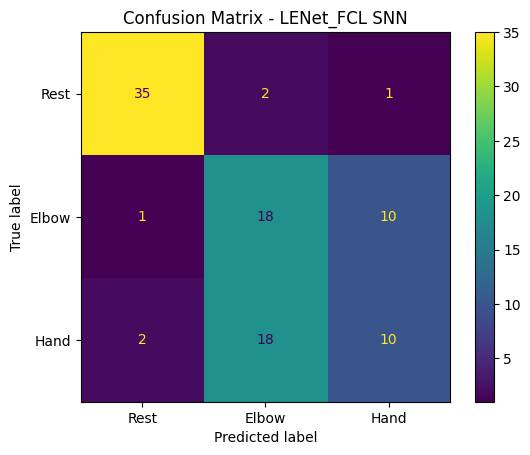


--- Model Performance Summary ---
| Model             | Overall Acc.    | Rest Acc.    | Elbow Acc.   | Hand Acc.    |
|-------------------|-----------------|--------------|--------------|--------------|
| LENet CNN         | 68.04%          | 94.74%       | 51.72%       | 50.00%       |
| LENet SNN         | 68.04%          | 97.37%       | 51.72%       | 46.67%       |
| LENet_FCL CNN     | 63.92%          | 78.95%       | 44.83%       | 63.33%       |
| LENet_FCL SNN     | 64.95%          | 92.11%       | 62.07%       | 33.33%       |


In [30]:
# @title Evaluate models and visualize results
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Ensure all necessary variables from previous cells are available:
# cnn_model_lenet, snn_model_lenet, cnn_model_lenet_fcl, snn_model_lenet_fcl
# test_data, test_label (from the last train_test_split)
# BATCH_SIZE, TIME_STEPS, device
# data_loader function

# 0. Prepare data loader for evaluation (using test_data from the last split)
# This ensures all models are evaluated on the same test set.
eval_test_loader = data_loader(test_data, test_label, batch=BATCH_SIZE, shuffle=False, drop=False)

true_labels_list = []
# Ensure targets are collected correctly from the loader
for _, targets_batch in eval_test_loader:
    true_labels_list.extend(targets_batch.cpu().numpy())
true_labels_np = np.array(true_labels_list)

# --- 1. Get predictions for LENet CNN ---
print("Evaluating LENet CNN...")
cnn_model_lenet.eval().to(device)
preds_lenet_cnn = []
with torch.no_grad():
    for inputs, _ in eval_test_loader:
        inputs = inputs.to(device)
        outputs = cnn_model_lenet(inputs)
        _, predicted = outputs.max(1)
        preds_lenet_cnn.extend(predicted.cpu().numpy())

# --- 2. Get predictions for LENet SNN ---
print("Evaluating LENet SNN...")
snn_model_lenet.eval().to(device)
preds_lenet_snn = []
with torch.no_grad():
    for inputs, _ in eval_test_loader:
        inputs = inputs.to(device)
        for m_module in snn_model_lenet.modules():
            if hasattr(m_module, 'reset'):
                m_module.reset()
        accumulated_outputs = None
        for t in range(TIME_STEPS):
            outputs_t = snn_model_lenet(inputs)
            if accumulated_outputs is None:
                accumulated_outputs = outputs_t.clone()
            else:
                accumulated_outputs += outputs_t
        _, predicted = accumulated_outputs.max(1)
        preds_lenet_snn.extend(predicted.cpu().numpy())

# --- 3. Get predictions for LENet_FCL CNN ---
print("Evaluating LENet_FCL CNN...")
cnn_model_lenet_fcl.eval().to(device)
preds_lenet_fcl_cnn = []
with torch.no_grad():
    for inputs, _ in eval_test_loader:
        inputs = inputs.to(device)
        outputs = cnn_model_lenet_fcl(inputs)
        _, predicted = outputs.max(1)
        preds_lenet_fcl_cnn.extend(predicted.cpu().numpy())

# --- 4. Get predictions for LENet_FCL SNN ---
print("Evaluating LENet_FCL SNN...")
snn_model_lenet_fcl.eval().to(device)
preds_lenet_fcl_snn = []
with torch.no_grad():
    for inputs, _ in eval_test_loader:
        inputs = inputs.to(device)
        for m_module in snn_model_lenet_fcl.modules():
            if hasattr(m_module, 'reset'):
                m_module.reset()
        accumulated_outputs = None
        for t in range(TIME_STEPS):
            outputs_t = snn_model_lenet_fcl(inputs)
            if accumulated_outputs is None:
                accumulated_outputs = outputs_t.clone()
            else:
                accumulated_outputs += outputs_t
        _, predicted = accumulated_outputs.max(1)
        preds_lenet_fcl_snn.extend(predicted.cpu().numpy())

# --- 5. Confusion Matrices ---
class_names_display = ['Rest', 'Elbow', 'Hand'] # For display purposes

# LENet CNN
cm_lenet_cnn = confusion_matrix(true_labels_np, preds_lenet_cnn)
disp_lenet_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_lenet_cnn, display_labels=class_names_display)
disp_lenet_cnn.plot()
plt.title('Confusion Matrix - LENet CNN')
plt.show()

# LENet SNN
cm_lenet_snn = confusion_matrix(true_labels_np, preds_lenet_snn)
disp_lenet_snn = ConfusionMatrixDisplay(confusion_matrix=cm_lenet_snn, display_labels=class_names_display)
disp_lenet_snn.plot()
plt.title('Confusion Matrix - LENet SNN')
plt.show()

# LENet_FCL CNN
cm_lenet_fcl_cnn = confusion_matrix(true_labels_np, preds_lenet_fcl_cnn)
disp_lenet_fcl_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_lenet_fcl_cnn, display_labels=class_names_display)
disp_lenet_fcl_cnn.plot()
plt.title('Confusion Matrix - LENet_FCL CNN')
plt.show()

# LENet_FCL SNN
cm_lenet_fcl_snn = confusion_matrix(true_labels_np, preds_lenet_fcl_snn)
disp_lenet_fcl_snn = ConfusionMatrixDisplay(confusion_matrix=cm_lenet_fcl_snn, display_labels=class_names_display)
disp_lenet_fcl_snn.plot()
plt.title('Confusion Matrix - LENet_FCL SNN')
plt.show()

# --- 6. Accuracy Table ---
print("\n--- Model Performance Summary ---")

model_predictions = {
    "LENet CNN": preds_lenet_cnn,
    "LENet SNN": preds_lenet_snn,
    "LENet_FCL CNN": preds_lenet_fcl_cnn,
    "LENet_FCL SNN": preds_lenet_fcl_snn
}

accuracy_results = {}
class_names = ['Rest', 'Elbow', 'Hand'] # Corresponds to labels 0, 1, 2

for model_name, predictions in model_predictions.items():
    overall_acc = accuracy_score(true_labels_np, predictions)
    accuracy_results[model_name] = {"Overall": overall_acc}
    for class_idx, class_name in enumerate(class_names):
        class_indices = np.where(true_labels_np == class_idx)[0]
        if len(class_indices) > 0:
            class_true = true_labels_np[class_indices]
            class_pred = np.array(predictions)[class_indices]
            class_acc = accuracy_score(class_true, class_pred)
            accuracy_results[model_name][class_name] = class_acc
        else:
            accuracy_results[model_name][class_name] = np.nan # Or 0, or "N/A"

# Print table
header = f"| {'Model':<17} | {'Overall Acc.':<15} | {class_names[0]+' Acc.':<12} | {class_names[1]+' Acc.':<12} | {class_names[2]+' Acc.':<12} |"
separator = "|-------------------|-----------------|--------------|--------------|--------------|"
print(header)
print(separator)

for model_name in accuracy_results:
    overall_str = f"{accuracy_results[model_name]['Overall']*100:.2f}%"
    rest_str = f"{accuracy_results[model_name][class_names[0]]*100:.2f}%" if not np.isnan(accuracy_results[model_name][class_names[0]]) else "N/A"
    elbow_str = f"{accuracy_results[model_name][class_names[1]]*100:.2f}%" if not np.isnan(accuracy_results[model_name][class_names[1]]) else "N/A"
    hand_str = f"{accuracy_results[model_name][class_names[2]]*100:.2f}%" if not np.isnan(accuracy_results[model_name][class_names[2]]) else "N/A"

    row = f"| {model_name:<17} | {overall_str:<15} | {rest_str:<12} | {elbow_str:<12} | {hand_str:<12} |"
    print(row)

